In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melanoma-image/melanoma.jpg
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle

In [5]:
!pip install autokeras==1.0.13
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 33.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 14.2 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77055 sha256=a8a856eea2981c30e01c64ef3bd6938cebc9f23d855061e76a9e48a5fe0213c2
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installatio

In [6]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [7]:
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')


In [8]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


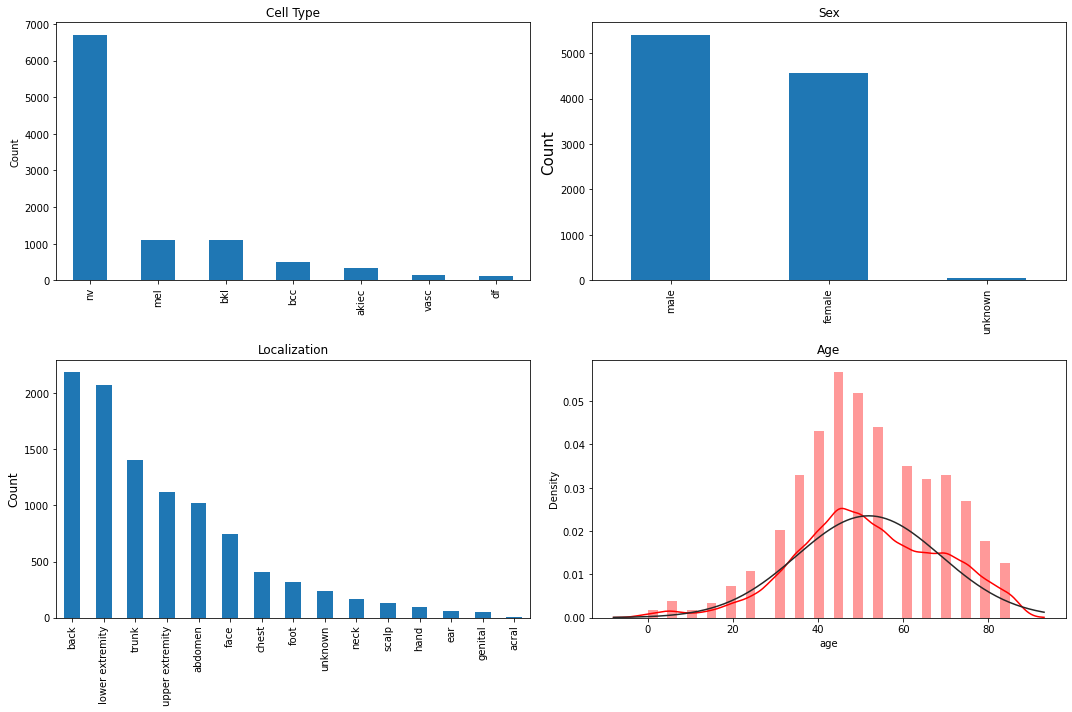

In [9]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [10]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [11]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [12]:

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/', '*', '*.jpg'))} #####provlhma edw
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)


0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [13]:
print(skin_df['image_id'].map(image_path.get))

0        /kaggle/input/skin-cancer-mnist-ham10000/ham10...
1        /kaggle/input/skin-cancer-mnist-ham10000/ham10...
2        /kaggle/input/skin-cancer-mnist-ham10000/ham10...
3        /kaggle/input/skin-cancer-mnist-ham10000/ham10...
4        /kaggle/input/skin-cancer-mnist-ham10000/ham10...
                               ...                        
10010    /kaggle/input/skin-cancer-mnist-ham10000/ham10...
10011    /kaggle/input/skin-cancer-mnist-ham10000/ham10...
10012    /kaggle/input/skin-cancer-mnist-ham10000/ham10...
10013    /kaggle/input/skin-cancer-mnist-ham10000/ham10...
10014    /kaggle/input/skin-cancer-mnist-ham10000/ham10...
Name: image_id, Length: 10015, dtype: object


In [14]:
print(skin_df_balanced)

        lesion_id      image_id     dx    dx_type   age     sex  \
9789  HAM_0003136  ISIC_0026645  akiec      histo  65.0    male   
9957  HAM_0006587  ISIC_0025780  akiec      histo  70.0    male   
9793  HAM_0005505  ISIC_0024450  akiec      histo  50.0    male   
9758  HAM_0003455  ISIC_0027896  akiec      histo  75.0    male   
9875  HAM_0005459  ISIC_0029268  akiec      histo  85.0    male   
...           ...           ...    ...        ...   ...     ...   
2375  HAM_0005989  ISIC_0033123   vasc      histo  25.0  female   
2436  HAM_0004943  ISIC_0027790   vasc  consensus  50.0  female   
2453  HAM_0001038  ISIC_0024706   vasc  consensus  50.0    male   
2377  HAM_0007097  ISIC_0033762   vasc      histo  60.0    male   
2363  HAM_0003862  ISIC_0033031   vasc      histo  45.0    male   

         localization  label  \
9789             back      0   
9957             face      0   
9793  upper extremity      0   
9758             hand      0   
9875  upper extremity      0   
...

In [15]:
#Use the path to read images.
SIZE = 32
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

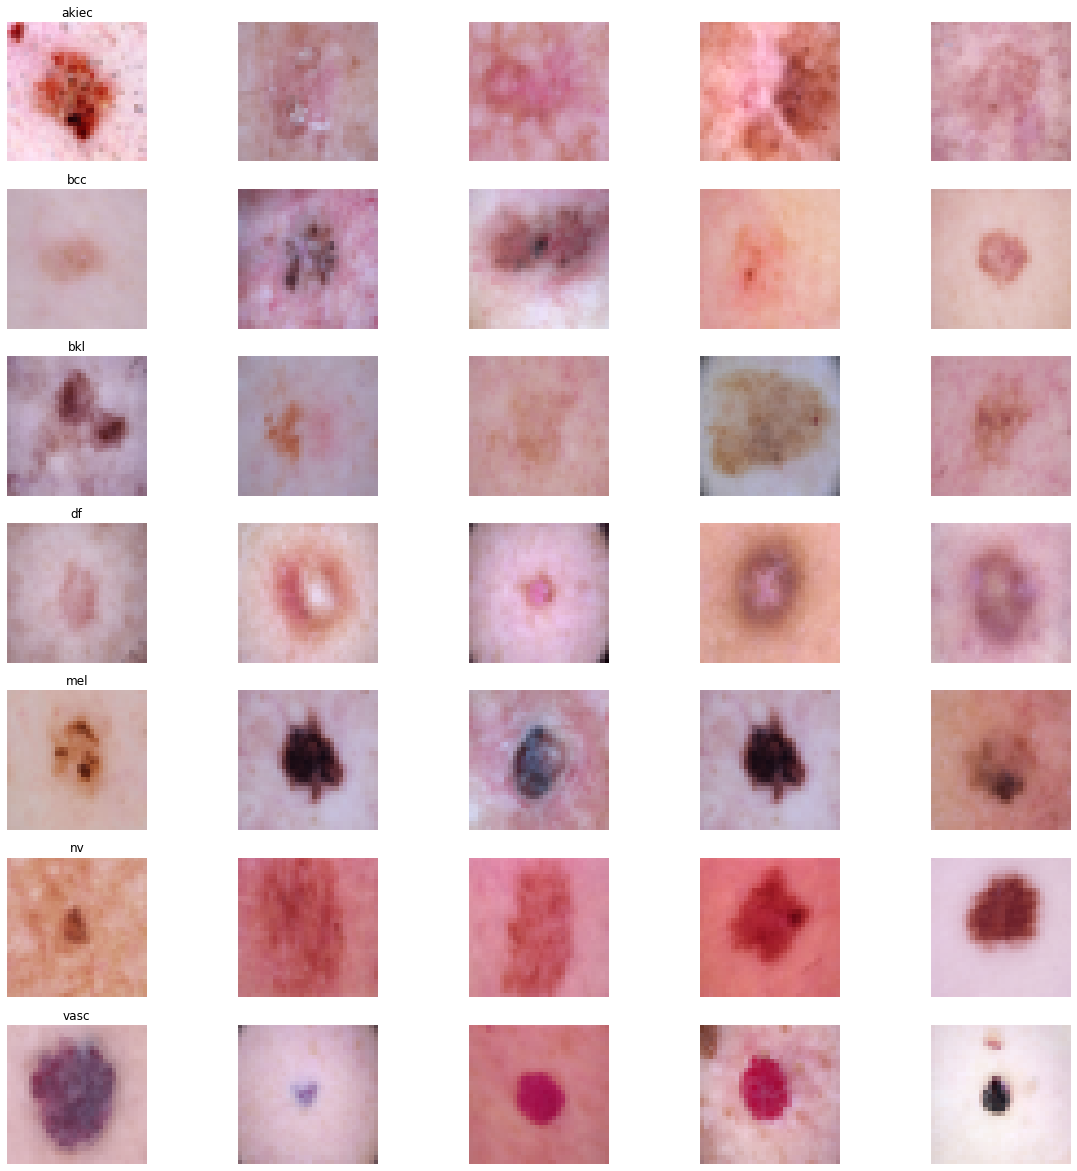

In [16]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

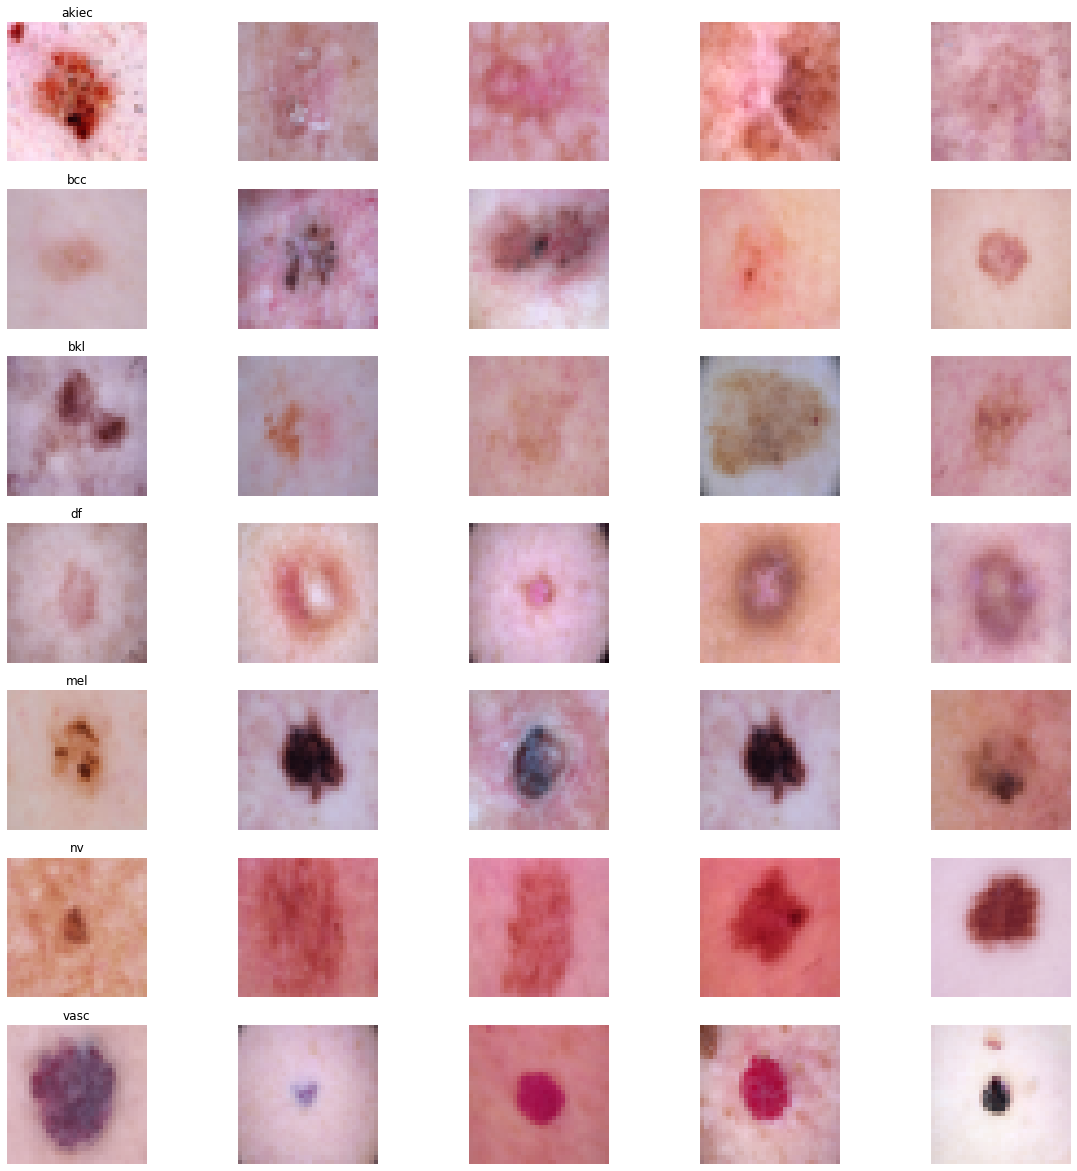

In [17]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [18]:
!pip install keras-sequential-ascii


  Preparing metadata (setup.py) ... done
  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3063 sha256=6ef66d46de0c3ea2369ba0c416f6bd727e320cd6f281b35dc21b04323d9c4899
  Stored in directory: /root/.cache/pip/wheels/4e/99/75/8910ced4b40e8c20088c237fa706b32ac758321482ae2659e3
Successfully built keras-sequential-ascii


In [19]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D ,MaxPool2D,Dropout,Flatten,Dense

num_classes = 7
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


2022-05-31 20:01:41.206694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:41.365433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:41.366254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:41.367764: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

node zero
2022-05-31 20:01:41.368790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:41.369489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:42.084459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:42.085342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:01:42.086011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [20]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
model.save("skin_cnn.model")
print('Test accuracy:', score[1])

Epoch 1/50


2022-05-31 20:01:42.626172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-31 20:01:44.471145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


165/165 - 9s - loss: 1.9145 - acc: 0.1890 - val_loss: 1.8439 - val_acc: 0.2354
Epoch 2/50
165/165 - 1s - loss: 1.7842 - acc: 0.2499 - val_loss: 1.7486 - val_acc: 0.2834
Epoch 3/50
165/165 - 1s - loss: 1.6202 - acc: 0.3352 - val_loss: 1.5045 - val_acc: 0.3760
Epoch 4/50
165/165 - 1s - loss: 1.5148 - acc: 0.3718 - val_loss: 1.5039 - val_acc: 0.3669
Epoch 5/50
165/165 - 1s - loss: 1.4694 - acc: 0.4042 - val_loss: 1.4270 - val_acc: 0.4057
Epoch 6/50
165/165 - 1s - loss: 1.4128 - acc: 0.4156 - val_loss: 1.3922 - val_acc: 0.4366
Epoch 7/50
165/165 - 1s - loss: 1.3753 - acc: 0.4400 - val_loss: 1.3667 - val_acc: 0.4469
Epoch 8/50
165/165 - 1s - loss: 1.3652 - acc: 0.4587 - val_loss: 1.3395 - val_acc: 0.4503
Epoch 9/50
165/165 - 1s - loss: 1.3087 - acc: 0.4762 - val_loss: 1.3296 - val_acc: 0.4709
Epoch 10/50
165/165 - 1s - loss: 1.2984 - acc: 0.4933 - val_loss: 1.2932 - val_acc: 0.4709
Epoch 11/50
165/165 - 1s - loss: 1.2708 - acc: 0.4994 - val_loss: 1.3341 - val_acc: 0.4434
Epoch 12/50
165/165

2022-05-31 20:02:26.397326: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Test accuracy: 0.678857147693634


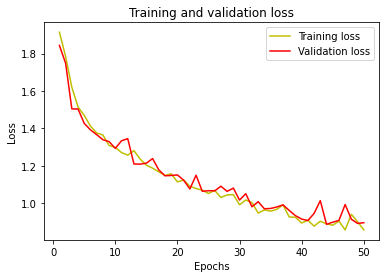

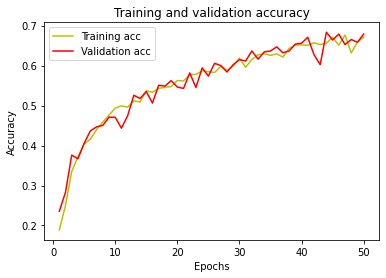

Text(33.0, 0.5, 'Fraction of incorrect predictions')

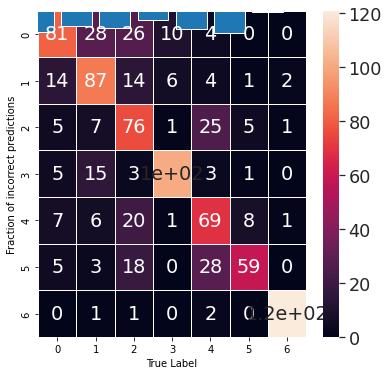

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [2]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
print(tf.__version__)
print(cv2.__version__)
print(np.__version__)
print(keras.__version__)
CATEGORIES = ["nv","mel","bkl","bcc","akiec","vas","df"]

2.6.4
4.5.4
1.21.6
2.6.0


In [3]:
def prepare(filepath):
    IMG_SIZE = 32
    img_array = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    print(img_array)
    print(img_array.shape)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE,))
    print(new_array)
    print(new_array.shape)
    np.reshape(new_array, new_array.shape + (IMG_SIZE,IMG_SIZE))
    print(new_array)
    print(new_array.shape)
    return new_array

model = tf.keras.models.load_model("./skin_cnn.model")

print(model)

prediction = model.predict([prepare("../input/melanoma-image/melanoma.jpg")])

OSError: SavedModel file does not exist at: ./skin_cnn.model/{saved_model.pbtxt|saved_model.pb}